In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Linear SVC with SGD

Load data

In [2]:
x_trn = pd.read_pickle("./data/x_train.pkl")
y_trn = pd.read_pickle("./data/y_train.pkl")
x_tst = pd.read_pickle("./data/x_test.pkl")
x_train_roc = pd.read_pickle("./data/x_train_roc.pkl")
y_train_roc = pd.read_pickle("./data/y_train_roc.pkl")
x_val_roc = pd.read_pickle("./data/x_val_roc.pkl")
y_val_roc = pd.read_pickle("./data/y_val_roc.pkl")

Set random seed

In [3]:
rng = np.random.RandomState(0)

Create cross-validation generator

In [4]:
cvg = StratifiedKFold(n_splits=5, shuffle=False)

Create an instance of the classifier we want to use

In [5]:
clf = SGDClassifier(loss='hinge', penalty='l2', random_state=rng)

Take a look at the parameters we'll need to create a grid for

In [6]:
clf.get_params(deep=False)

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': RandomState(MT19937) at 0x7FBC0B26CC40,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Create parameter grid

In [7]:
param_grid = {'alpha':np.logspace(-5,-3,num=20,base=10,dtype='float'),
              'tol':np.logspace(-5,-3,num=20,base=10,dtype='float')}

Create successive halving grid search cross-validation estimator

In [8]:
search = HalvingGridSearchCV(estimator=clf, 
                             param_grid=param_grid, 
                             factor=2,
                             cv=cvg, 
                             random_state=rng)
search.fit(x_trn, y_trn)
print(search.best_estimator_)
print(search.best_params_)

SGDClassifier(alpha=0.001, random_state=RandomState(MT19937) at 0x7FBC0B371640)
{'alpha': 0.001, 'tol': 0.001}


Create and save successive halving heatmap https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#

In [9]:
#TODO

Plot and save candidate scores over successive halving iterations https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html#

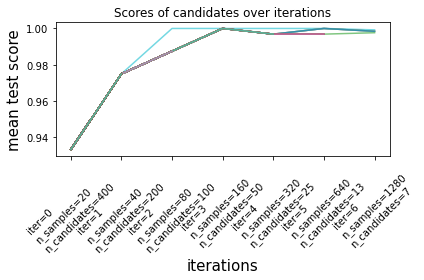

In [10]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()
#TODO: save plot

Plot and save feature importance scores to determine top features https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

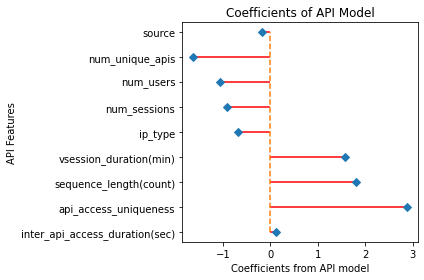

In [59]:
coef = clf.coef_
coef = coef[0,:]
features = x_trn.columns
arg_rank = np.argsort(-np.abs(coef))


arg_rank

used_features = 9#len(features)

# Plot coefficient chart
plt.hlines( np.arange(used_features),0,coef, color='red')
plt.plot(coef, np.arange(used_features), 'D')
plt.plot([0, 0], [np.arange(used_features).min(), np.arange(used_features).max()], '--')
plt.title("Coefficients of API Model")
plt.ylabel("API Features")
plt.xlabel("Coefficients from API model")
plt.yticks(np.arange(used_features),features)
plt.tight_layout()

Plot and save AUROC curve

training score:1.0
validation score:1.0


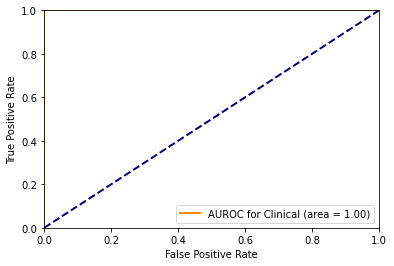

In [12]:
clf_roc = SGDClassifier(loss='hinge', penalty='l2', random_state=rng)
clf_roc.set_params(**search.best_params_)
clf_roc.fit(x_train_roc, y_train_roc)
y_pred_roc = clf_roc.predict(x_val_roc)

fpr, tpr, _ = roc_curve(y_val_roc, y_pred_roc, pos_label=1)
roc_auc = auc(fpr, tpr)	

AUC = metrics.auc(fpr, tpr)
AUC

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUROC for Clinical (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('training score:' + str(clf_roc.score(x_train_roc, y_train_roc)))
print('validation score:' + str(clf_roc.score(x_val_roc,y_val_roc)))

Set classifier parameters to optimal values identified by cross-validation and fit on entire training set, then output predictions on test set

In [13]:
clf.set_params(**search.best_params_)
clf.fit(x_trn, y_trn)

#we need to decide what to do with these predictions, since it's an unlabeled test set.
y_pred = clf.predict(x_tst)
pickle.dump(y_pred,open("./data/y_pred_LinearSVC_SGD.pkl", "wb"))

clf.score(x_trn, y_trn)

1.0